In [9]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from cleanlab.classification import LearningWithNoisyLabels

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance

from scipy.stats import f_oneway

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

In [11]:
data = pd.read_csv("gen_info_model.csv")
data = data.loc[:, ~data.columns.str.match('Unnamed')]

In [12]:
x_data_pd = data.loc[:, ~data.columns.str.match('one')]
y_data_pd = data[['one']]
#Делим на тестовую и обучающую
x_train_pd, x_test_pd, y_train_pd, y_test_pd = train_test_split(x_data_pd, y_data_pd, test_size=0.2, random_state=42)

In [13]:
x_train = x_train_pd.to_numpy()
x_test = x_test_pd.to_numpy()
y_train = y_train_pd.to_numpy()
y_test = y_test_pd.to_numpy()
x_data = x_data_pd.to_numpy()
y_data = y_data_pd.to_numpy()

In [14]:
x_train_pd

,diff_date,dev_price,n_au,met_before,ratio_win_proc,firm_live,res_dev,length,moskva,firm_by_au
2769336,0,0.495000,13,0,0.000000,1000,0.320000,7,1,1.000000
280285,1440,0.996169,90,1,0.079545,751,0.417600,6,0,0.444444
5559,1500,0.666208,2,0,0.000000,4,0.426000,10,0,0.407407
326441,588840,0.983607,4,1,0.500000,1336,0.488000,9,1,0.430693
591551,11400,0.771208,7,0,0.750000,464,0.280080,21,0,0.303426
...,...,...,...,...,...,...,...,...,...,...
1692743,515400,1.000000,16,1,0.357143,1129,0.960000,9,0,0.702703
2356330,691920,0.997537,72,1,0.518518,1338,0.812000,10,0,0.272994
2229084,75840,0.976539,4087,1,0.000000,1232,0.817984,9,0,0.329032
2768307,1620,0.915462,4087,1,0.008705,1232,0.410940,6,1,0.506702


In [7]:
parameters = {
    "learning_rate": [0.05, 0.1],
    "max_depth":[3,5],
    "subsample":[0.8, 1.0],
    "n_estimators":[200, 300]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=-1)

clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.best_params_)

0.843649720478718
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


In [15]:
# Классификатор с оттюниными параметрами
xgb = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 300, subsample = 0.8)

<AxesSubplot:>

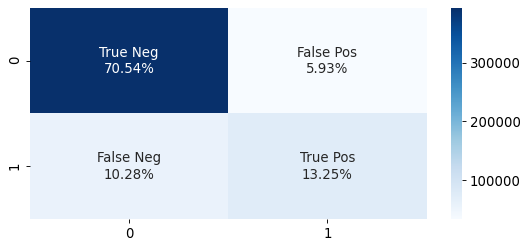

In [12]:
#Without noisy labels
xgb.fit(x_train, np.ravel(y_train))
# Estimate the predictions
predicted_test_labels = xgb.predict_proba(x_data)
cf = confusion_matrix(y_data, predicted_test_labels)
#Plot confusion matrix
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

In [18]:
xgb_noisy = LearningWithNoisyLabels(clf=xgb)
xgb_noisy.fit(X=x_train, s= np.ravel(y_train))
# Estimate the predictions you would have gotten by training with *no* label errors.
predicted_labels = xgb_noisy.predict_proba(x_data)
#cf = confusion_matrix(y_data, predicted_labels)
#Plot confusion matrix
#group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
#group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
#labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
#labels = np.asarray(labels).reshape(2,2)
#sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

In [17]:
predicted_labels

array([[9.97925356e-01, 2.07464361e-03],
       [9.99823624e-01, 1.76376372e-04],
       [9.99538759e-01, 4.61241207e-04],
       ...,
       [4.20028823e-01, 5.79971177e-01],
       [9.99785259e-01, 2.14741485e-04],
       [3.70787082e-01, 6.29212918e-01]])

In [19]:
xgb_all_test_labels = pd.DataFrame(predicted_labels, columns = ['Column_A','Column_B'])
xgb_all_test_labels.to_csv(r'C:\Users\ASUS\Documents\KR\RMD\test_labels_xgb_all_probs.csv')
#accuracy_score(y_data, predicted_labels)

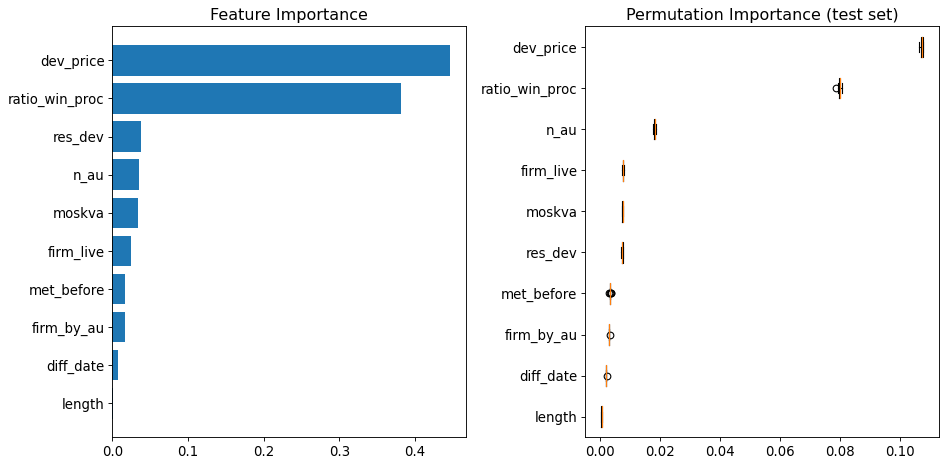

In [27]:
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(x_train_pd.columns)[sorted_idx])
plt.title('Feature Importance')

result = permutation_importance(xgb, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(x_train_pd.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()


In [12]:
#Преобразовываем до нужного формата
test_labels_xgb = pd.read_csv("test_labels_xgb.csv")
test_labels_xgb = test_labels_xgb.loc[:, ~test_labels_xgb.columns.str.match('Unnamed')]
test_labels_xgb["predicted_xgb"] = test_labels_xgb["0"]
test_labels_xgb = test_labels_xgb.loc[:, ~test_labels_xgb.columns.str.match('0')]
test_labels_xgb = test_labels_xgb.set_index(y_test_pd.index)

test_sample = pd.concat([x_test_pd, y_test_pd], axis=1)
test_sample = pd.concat([test_sample, test_labels_xgb], axis=1)

In [13]:
conditions = [
    (test_sample['one'] == 0) & (test_sample['predicted_xgb'] == 0),
    (test_sample['one'] == 0) & (test_sample['predicted_xgb'] == 1),
    (test_sample['one'] == 1) & (test_sample['predicted_xgb'] == 0),
    (test_sample['one'] == 1) & (test_sample['predicted_xgb'] == 1)
    ]

# create a list of the values we want to assign for each condition
values = ['true_neg', 'false_pos', 'false_neg', 'true_pos']

# create a new column and use np.select to assign values to it using our lists as arguments
test_sample['category_xgb'] = np.select(conditions, values)

<AxesSubplot:xlabel='category_xgb', ylabel='dev_price'>

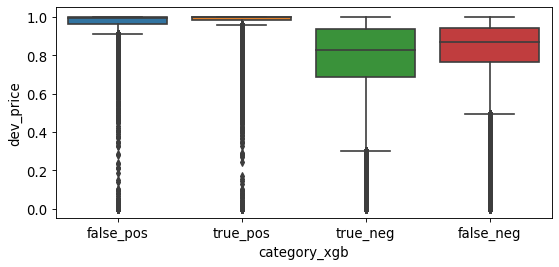

In [31]:
sns.boxplot(x="category_xgb", y="dev_price", data=test_sample)

<AxesSubplot:xlabel='category_xgb', ylabel='ratio_win_proc'>

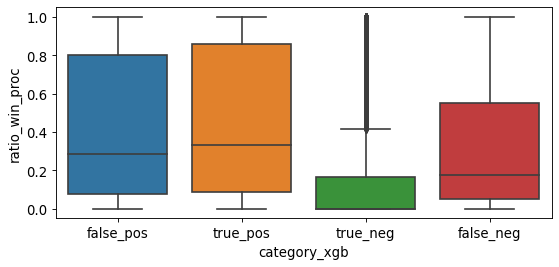

In [33]:
sns.boxplot(x="category_xgb", y="ratio_win_proc", data=test_sample)

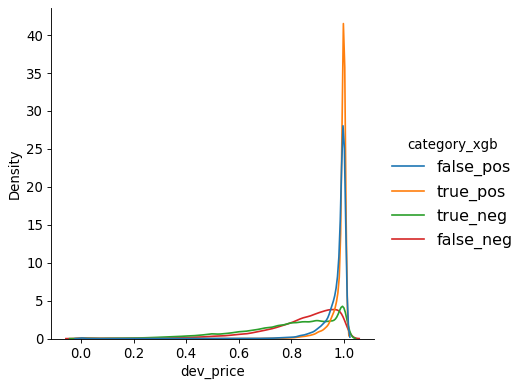

In [35]:
sns.displot(data = test_sample, x= "dev_price", kind="kde", hue="category_xgb", common_norm=False)

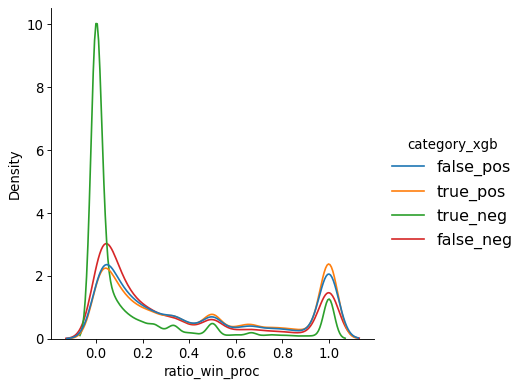

In [36]:
sns.displot(data = test_sample, x= "ratio_win_proc", kind="kde", hue="category_xgb", common_norm=False)

In [37]:
#Насколько соотносятся labels и DEDPUL
dedpul = pd.read_csv("dedpul_data.csv")
dedpul = dedpul.loc[:, ~dedpul.columns.str.match('Unnamed')]
dedpul["one"] = 1
dedpul = dedpul.round({'probs': 4})
dedpul = dedpul.drop_duplicates()

In [38]:
column_names = ['diff_date',
 'dev_price',
 'n_au',
 'met_before',
 'ratio_win_proc',
 'firm_live',
 'res_dev',
 'length',
 'moskva',
 'firm_by_au',
 'one']

test_sample = pd.merge(test_sample, dedpul, how = "left", on = column_names)
one_test = test_sample[test_sample['one'] == 1]

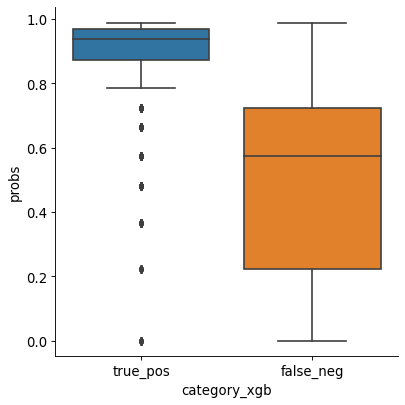

In [39]:
sns.catplot(x="category_xgb", y="probs", kind="box", data=one_test)

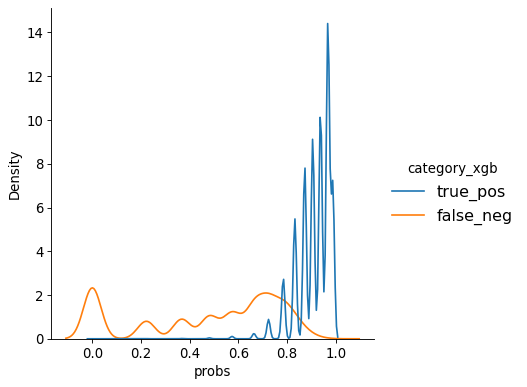

In [40]:
sns.displot(data = one_test, x= "probs", kind="kde", hue="category_xgb", common_norm=False)

In [20]:
xgb_pu = LearningWithNoisyLabels(clf=xgb, pulearning = 0)
xgb_pu.fit(X=x_train, s= np.ravel(y_train))
# Estimate the predictions you would have gotten by training with *no* label errors.
predicted_labels = xgb_pu.predict_proba(x_data)
#cf = confusion_matrix(y_data, predicted_labels)
#Plot confusion matrix
#group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
#group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
#labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
#labels = np.asarray(labels).reshape(2,2)
#sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

In [21]:
xgbpu_all_labels = pd.DataFrame(predicted_labels, columns = ['Column_A','Column_B'])
xgbpu_all_labels.to_csv(r'C:\Users\ASUS\Documents\KR\RMD\labels_xgb_pu_all_probs.csv')
#accuracy_score(y_data, predicted_labels)

In [14]:
#Преобразовываем до нужного формата
test_labels_xgb_pu = pd.read_csv("test_labels_xgb_pu.csv")
test_labels_xgb_pu = test_labels_xgb_pu.loc[:, ~test_labels_xgb_pu.columns.str.match('Unnamed')]
test_labels_xgb_pu["predicted_xgb_pu"] = test_labels_xgb_pu["0"]
test_labels_xgb_pu = test_labels_xgb_pu.loc[:, ~test_labels_xgb_pu.columns.str.match('0')]
test_labels_xgb_pu = test_labels_xgb_pu.set_index(y_test_pd.index)

test_sample = pd.concat([test_sample, test_labels_xgb_pu], axis=1)
test_sample.head()

,diff_date,dev_price,n_au,met_before,ratio_win_proc,firm_live,res_dev,length,moskva,firm_by_au,one,predicted_xgb,category_xgb,predicted_xgb_pu
2600133,503100,0.984651,106,0,0.056818,1336,0.811110,13,0,0.592040,0,1,false_pos,0
349428,700500,1.000000,11,0,0.100000,860,0.652026,14,0,0.348921,1,1,true_pos,1
2407844,87000,0.864957,125,1,0.191176,1249,0.090313,7,0,0.430851,0,0,true_neg,0
2745445,79380,1.000000,19,0,0.142857,1372,0.139200,7,1,0.781759,1,1,true_pos,1
681624,600,0.730250,184,0,0.012048,1220,0.133927,7,0,0.720000,1,0,false_neg,0


In [15]:
conditions = [
    (test_sample['one'] == 0) & (test_sample['predicted_xgb_pu'] == 0),
    (test_sample['one'] == 0) & (test_sample['predicted_xgb_pu'] == 1),
    (test_sample['one'] == 1) & (test_sample['predicted_xgb_pu'] == 0),
    (test_sample['one'] == 1) & (test_sample['predicted_xgb_pu'] == 1)
    ]

# create a list of the values we want to assign for each condition
values = ['true_neg', 'false_pos', 'false_neg', 'true_pos']

# create a new column and use np.select to assign values to it using our lists as arguments
test_sample['category_xgb_pu'] = np.select(conditions, values)

In [16]:
#Насколько соотносятся labels и DEDPUL
dedpul = pd.read_csv("dedpul_data.csv")
dedpul = dedpul.loc[:, ~dedpul.columns.str.match('Unnamed')]
dedpul["one"] = 1
dedpul = dedpul.round({'probs': 4})
dedpul = dedpul.drop_duplicates()

In [17]:
column_names = ['diff_date',
 'dev_price',
 'n_au',
 'met_before',
 'ratio_win_proc',
 'firm_live',
 'res_dev',
 'length',
 'moskva',
 'firm_by_au',
 'one']

test_sample = pd.merge(test_sample, dedpul, how = "left", on = column_names)
one_test = test_sample[test_sample['one'] == 1]

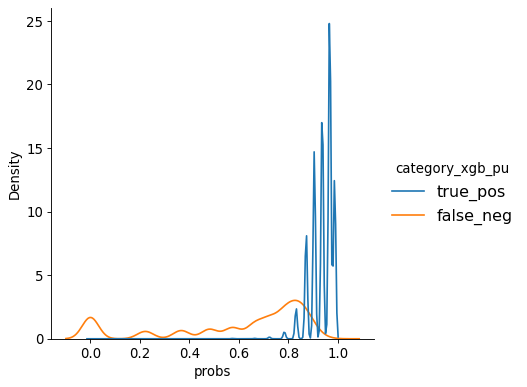

In [18]:
sns.displot(data = one_test, x= "probs", kind="kde", hue="category_xgb_pu", common_norm=False)